In [30]:
%%time
import os
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, optimizers, Model, Input, Sequential
import matplotlib.pyplot as plt

Wall time: 45.6 s


In [31]:
def get_MNIST_data():
    (mnist_data, _), _ = mnist.load_data()
    # Scale images to the [0, 1] range
    # mnist_data = np.concatenate((train_x, test_x), axis=0)
    mnist_data = (mnist_data.astype("float32") - 127.5) / 127.5
    # Make sure images have shape (28, 28, 1)
    img_shape = mnist_data[0].shape
    mnist_data = np.reshape(mnist_data, (-1, *img_shape, 1))
    print(f"Data shape: {mnist_data.shape}.")
    return mnist_data

In [32]:
mnist_data = get_MNIST_data()
input_shape = mnist_data[0].shape

Data shape: (60000, 28, 28, 1).


In [4]:
def get_discriminator(input_shape):
    img_input = Input(shape=input_shape, name="image_input", dtype=tf.float32)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer="l2")(img_input)
    x = layers.Conv2D(filters=64, kernel_size=5, activation="relu", kernel_regularizer="l2")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation="relu", kernel_regularizer="l2")(x)
    x = layers.Dense(10, activation="relu", kernel_regularizer="l2")(x)
    sx = layers.Dense(10, activation="tanh", kernel_regularizer="l2")(x)
    x = layers.Multiply()([sx, x])
    probs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs=[img_input], outputs=[probs])
    opt = optimizers.Adam(learning_rate=3e-4, beta_1=0.5)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["acc"])
    return model

In [5]:
def get_generator(latent_size):
    latent_input = Input(shape=latent_size, name="latent_input", dtype=tf.float32)
    x = layers.Dense(7*7*64, activation="relu", kernel_regularizer="l2")(latent_input)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2D(filters=64, kernel_size=5, activation="relu", padding="same", kernel_regularizer="l2")(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(filters=32, kernel_size=3, activation="relu", padding="same", kernel_regularizer="l2")(x)
    x = layers.UpSampling2D()(x)
    img = layers.Conv2D(filters=1, kernel_size=3, padding="same", activation="tanh")(x)
    model = Model(inputs=[latent_input], outputs=[img])
    return model

In [6]:
def get_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = optimizers.Adam(learning_rate=3e-4, beta_1=0.5)
    model.compile(optimizer=opt, loss="binary_crossentropy")
    return model

In [7]:
class Sampler:
    def __init__(self, dataset, g_model, batch_size, latent_size):
        self.g_model = g_model
        self.batch_size = batch_size
        self.latent_size = latent_size
        self.latent_shape = (batch_size, latent_size)
        self.dataset = dataset
        self.dataset_size = dataset.shape[0]
        self.data_index = 0
        self.indexes = np.arange(dataset.shape[0])
        self.shuffle_indexes()
        
    def shuffle_indexes(self):
        np.random.shuffle(self.indexes)
        
    def sample_latent(self, batch_size=None):
        batch_size = batch_size or self.batch_size
        latent = np.random.randn(batch_size, self.latent_size)
        return latent
        
    def sample_real_data(self):
        data = self.dataset[self.data_index:self.data_index+self.batch_size]
        self.data_index += self.batch_size
        if self.data_index >= self.dataset_size:
            self.data_index = 0
            self.shuffle_indexes()
        return data
    
    def sample_fake_data(self, latent):
        data = self.g_model.predict(latent)
        return data
    
    def sample_data(self, latent):
        fake_data = self.sample_fake_data(latent)
        real_data = self.sample_real_data()
        data = np.concatenate((fake_data, real_data), axis=0)
        labels = np.concatenate((np.zeros(fake_data.shape[0]), np.ones(real_data.shape[0])), axis=0)
        return data, labels

In [8]:
class ProgressBar:
    """
    Progress bar
    """
    def __init__(self, total_iter, display_text="Progress", max_bar_size=50, display_interval=1,
                 change_line_at_reset=True, done_char="█", undone_char="░"):
        """
        Constructor function
        :param total_iter: (int) Max iteration size for 100%
        :param display_text: (str) Display text at left of progress bar
        :param max_bar_size: (int) Maximum character size for 100%
        :param display_interval: (int) Display every given iterations
        :param change_line_at_reset: (bool) Change line when reset
        :param done_char: (str) Character for completed progress
        :param undone_char: (str) Character for left progress
        """
        self.total_iter = total_iter
        self.display_text = display_text
        self.max_bar_size = max_bar_size
        self.display_interval = display_interval
        self.change_line = change_line_at_reset
        self.done_char = done_char
        self.undone_char = undone_char
        self._current_iter = 0

    def reset(self):
        self._current_iter = 0
        if self.change_line:
            print()

    def display(self, add_text):
        """
        Display progress bar with additional text at the right of the progress bar
        :param add_text: (str) Additional text
        :return: None
        """
        progress_ratio = self._current_iter / self.total_iter
        bar_size = int(progress_ratio * self.max_bar_size)
        current_bar = bar_size * self.done_char
        print(f"\r{self.display_text} {current_bar:{self.undone_char}<{self.max_bar_size}}"
              f" {100 * progress_ratio:>6.2f}% ({self._current_iter:>3}/{self.total_iter:<3}) {add_text}",
              flush=True, end="")

    def step(self, num=1, add_text=""):
        """
        Take given number of steps
        :param num: (int) Step number
        :param add_text: (str) Additional text
        :return: None
        """
        self._current_iter = min(self._current_iter + num, self.total_iter)
        if (self._current_iter == self.total_iter) or (not self._current_iter % self.display_interval):
            self.display(add_text)
        if self._current_iter == self.total_iter:
            self.reset()

In [9]:
def plot_images(fig, cols, imgs):
    rows, rem = divmod(len(imgs), cols)
    if rem:
        rows += 1
    for i, img in enumerate(imgs, start=1):
        fig.add_subplot(rows, cols, i)
        plt.imshow(img[:, :, 0], cmap="gray")
    plt.show()

In [10]:
%%time
latent_size = 100
batch_size = 128
gen_model = get_generator(latent_size=latent_size)
dis_model = get_discriminator(input_shape=input_shape)
gan_model = get_gan(gen_model, dis_model)
sampler = Sampler(mnist_data, gen_model, batch_size=batch_size, latent_size=latent_size)

W1221 18:44:48.889588 15912 deprecation.py:506] From c:\users\raj k\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W1221 18:44:49.065611 15912 deprecation.py:323] From c:\users\raj k\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Wall time: 386 ms


In [11]:
epochs = 200
pretrain_epochs = 5
evaluate_num = 5
train_per_epoch = int(mnist_data.shape[0]/batch_size)
gen_images = []
train_info = {
    "dis_real_loss": [],
    "dis_real_acc": [],
    "dis_fake_loss": [],
    "dis_fake_acc": [],
    "gen_loss": []
}

In [12]:
p_bar = ProgressBar(total_iter=pretrain_epochs, display_text="Pre-training discriminator:", display_interval=10)
for epoch in range(1, pretrain_epochs+1):
    latent_vectors = sampler.sample_latent()
    fake_data = sampler.sample_fake_data(latent_vectors)
    dis_fake_loss, dis_fake_acc = dis_model.train_on_batch(fake_data, np.zeros((fake_data.shape[0], 1)))
    real_data = sampler.sample_real_data()
    dis_real_loss, dis_real_acc = dis_model.train_on_batch(real_data, np.ones((real_data.shape[0], 1)))
    p_bar.step(add_text=f":: Epoch: {epoch} :: dis (fake and real)(loss-acc): ({dis_fake_loss:.4f}, {dis_fake_acc:.4f}), ({dis_real_loss:.4f}, {dis_real_acc:.4f})")

W1221 18:44:53.770111 15912 training.py:2089] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W1221 18:44:54.458707 15912 training.py:2089] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Pre-training discriminator: ██████████████████████████████████████████████████ 100.00% (  5/5  ) :: Epoch: 5 :: dis (fake and real)(loss-acc): (2.7064, 0.0000), (1.9716, 1.0000)


W1221 18:44:54.639924 15912 training.py:2089] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W1221 18:44:54.655813 15912 training.py:2089] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?




Training for 200 epochs with 468 iterations per epoch
Training: ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5.00% (4680/93600) :: Epoch: 10 :: dis (fake and real)(loss-acc): (0.7131, 0.7656), (0.8418, 0.6875) :: gen loss: 2.2473

# Epoch 10


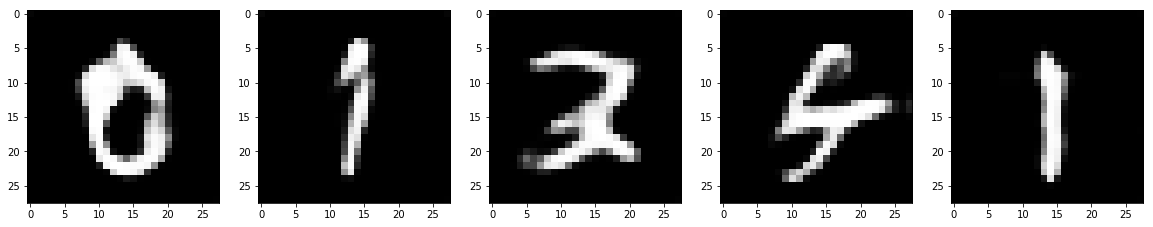

Training: █████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  10.00% (9360/93600) :: Epoch: 20 :: dis (fake and real)(loss-acc): (0.6008, 0.8750), (0.6301, 0.8281) :: gen loss: 2.8349

# Epoch 20


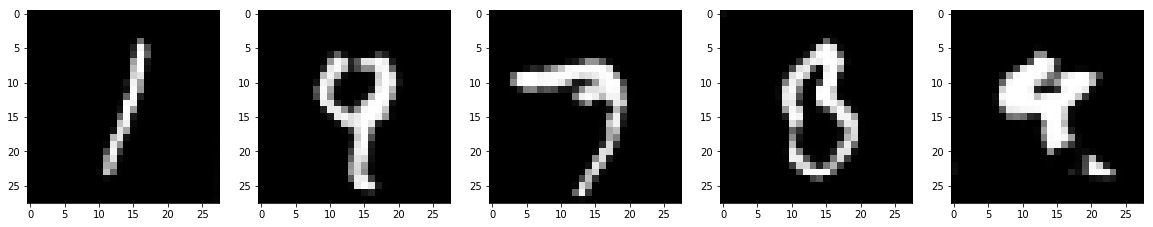

Training: ███████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  15.00% (14040/93600) :: Epoch: 30 :: dis (fake and real)(loss-acc): (0.4031, 0.9688), (0.5666, 0.8359) :: gen loss: 3.4335

# Epoch 30


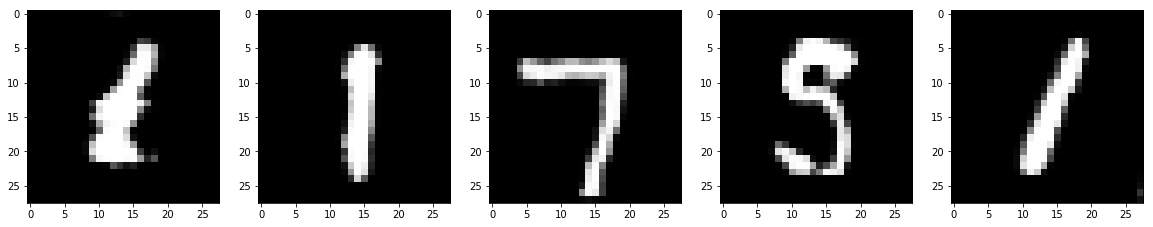

Training: ██████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  20.00% (18720/93600) :: Epoch: 40 :: dis (fake and real)(loss-acc): (0.5301, 0.9219), (0.5019, 0.8750) :: gen loss: 4.0454

# Epoch 40


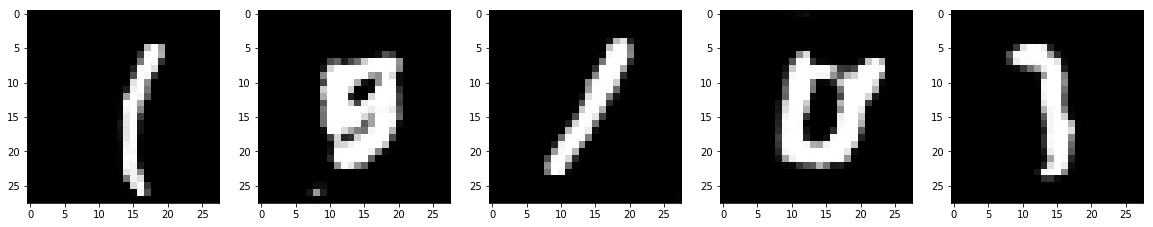

Training: ████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  25.00% (23400/93600) :: Epoch: 50 :: dis (fake and real)(loss-acc): (0.3224, 0.9844), (0.3702, 0.9219) :: gen loss: 4.3695

# Epoch 50


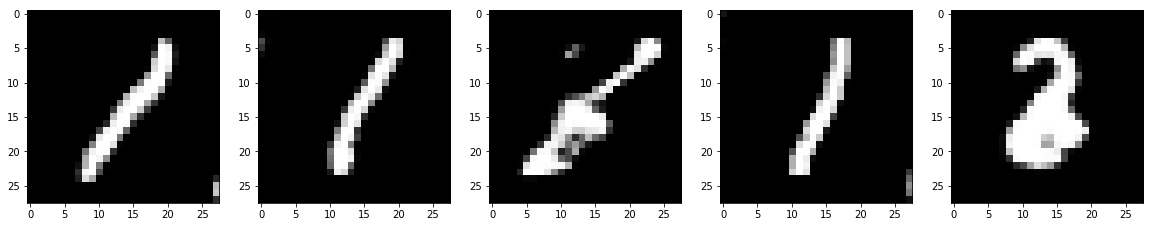

Training: ███████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  30.00% (28080/93600) :: Epoch: 60 :: dis (fake and real)(loss-acc): (0.3631, 0.9688), (0.4237, 0.9062) :: gen loss: 3.9175

# Epoch 60


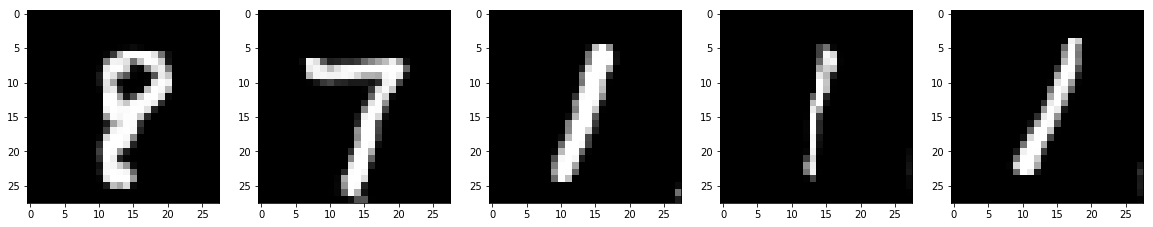

Training: █████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  35.00% (32760/93600) :: Epoch: 70 :: dis (fake and real)(loss-acc): (0.2759, 0.9922), (0.4382, 0.9141) :: gen loss: 4.6998

# Epoch 70


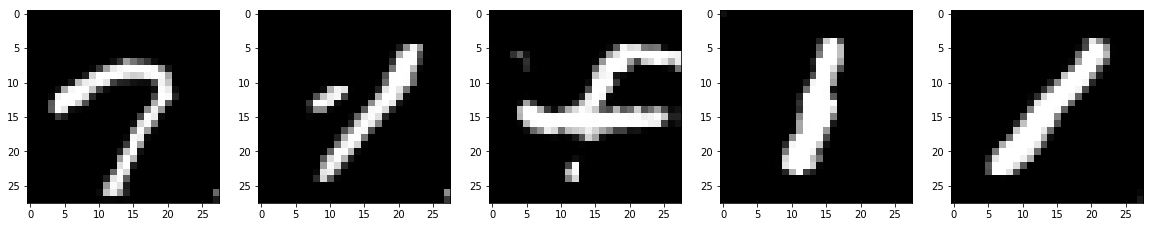

Training: ████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  40.00% (37440/93600) :: Epoch: 80 :: dis (fake and real)(loss-acc): (0.3176, 0.9766), (0.3722, 0.9453) :: gen loss: 4.8719

# Epoch 80


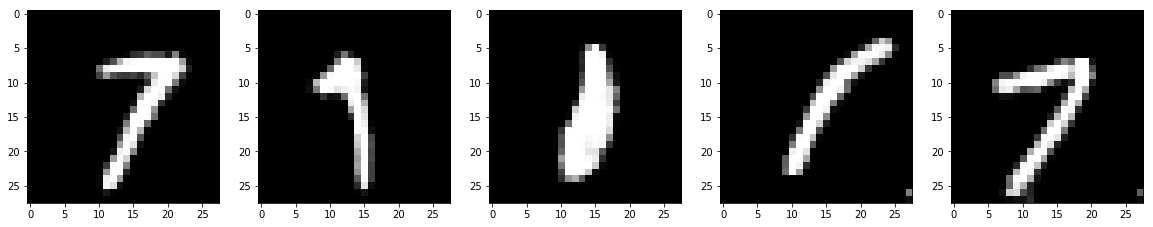

Training: ██████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░  45.00% (42120/93600) :: Epoch: 90 :: dis (fake and real)(loss-acc): (0.3152, 0.9766), (0.5039, 0.8594) :: gen loss: 3.7287

# Epoch 90


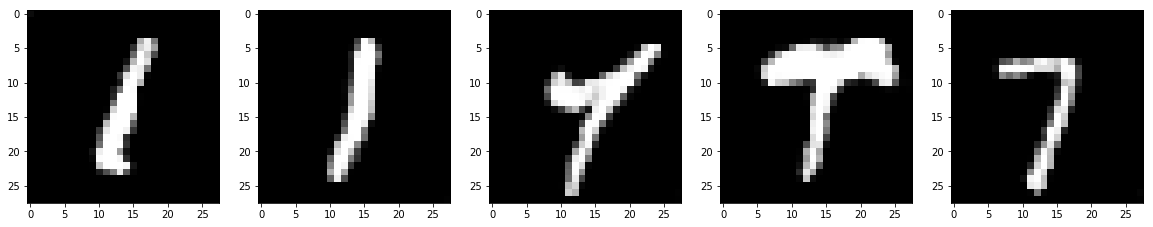

Training: █████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░  50.00% (46800/93600) :: Epoch: 100 :: dis (fake and real)(loss-acc): (0.2444, 0.9844), (0.3069, 0.9375) :: gen loss: 4.7454

# Epoch 100


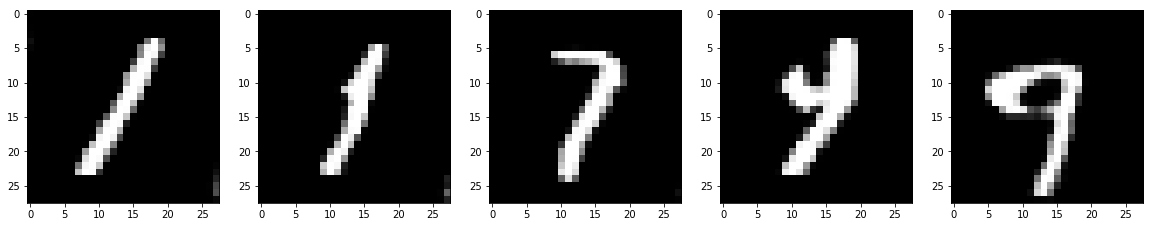

Training: ███████████████████████████░░░░░░░░░░░░░░░░░░░░░░░  55.00% (51480/93600) :: Epoch: 110 :: dis (fake and real)(loss-acc): (0.4443, 0.9219), (0.2870, 0.9531) :: gen loss: 5.1877

# Epoch 110


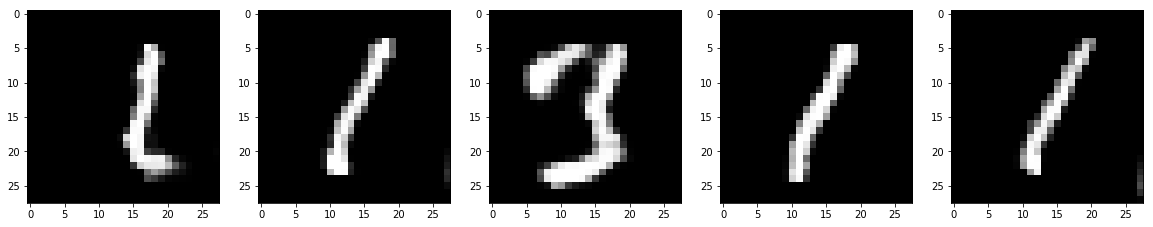

Training: ██████████████████████████████░░░░░░░░░░░░░░░░░░░░  60.00% (56160/93600) :: Epoch: 120 :: dis (fake and real)(loss-acc): (0.2203, 0.9922), (0.2852, 0.9453) :: gen loss: 5.2012

# Epoch 120


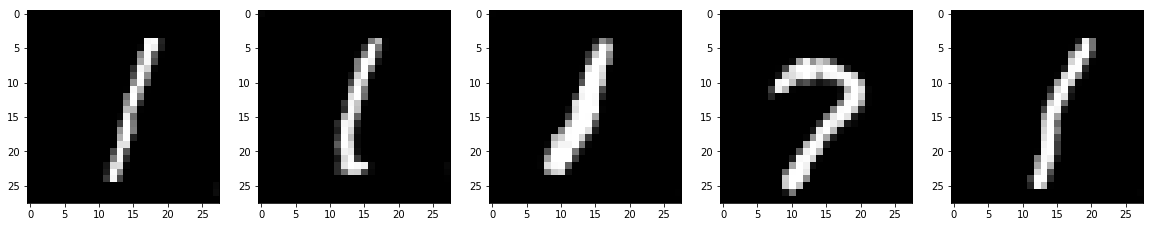

Training: ████████████████████████████████░░░░░░░░░░░░░░░░░░  65.00% (60840/93600) :: Epoch: 130 :: dis (fake and real)(loss-acc): (0.2812, 0.9844), (0.3985, 0.9141) :: gen loss: 4.3225

# Epoch 130


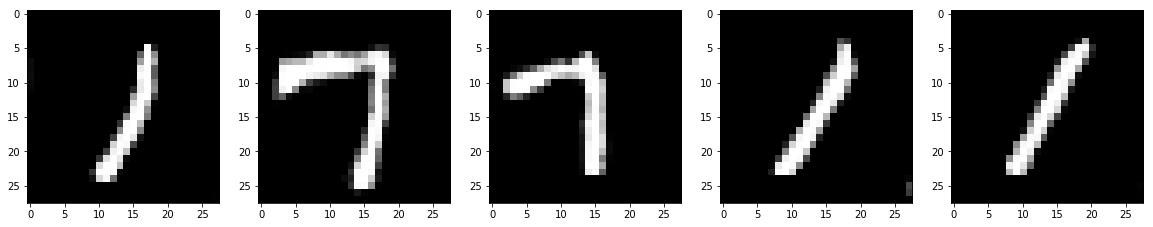

Training: ███████████████████████████████████░░░░░░░░░░░░░░░  70.00% (65520/93600) :: Epoch: 140 :: dis (fake and real)(loss-acc): (0.2112, 1.0000), (0.2936, 0.9609) :: gen loss: 4.6139

# Epoch 140


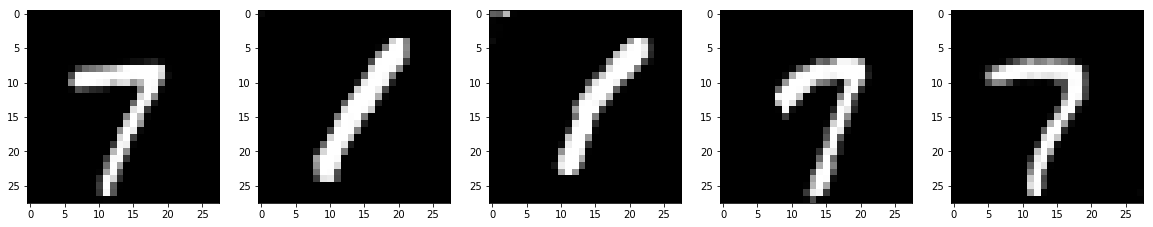

Training: █████████████████████████████████████░░░░░░░░░░░░░  75.00% (70200/93600) :: Epoch: 150 :: dis (fake and real)(loss-acc): (0.2220, 1.0000), (0.3146, 0.9297) :: gen loss: 4.6011

# Epoch 150


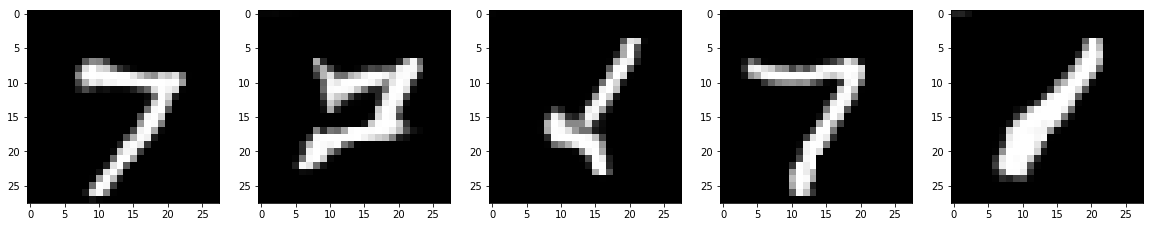

Training: ████████████████████████████████████████░░░░░░░░░░  80.00% (74880/93600) :: Epoch: 160 :: dis (fake and real)(loss-acc): (0.2364, 0.9922), (0.2612, 0.9688) :: gen loss: 5.1495

# Epoch 160


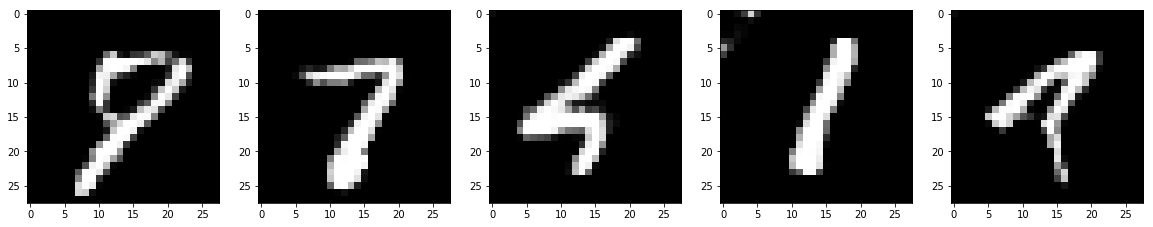

Training: ██████████████████████████████████████████░░░░░░░░  85.00% (79560/93600) :: Epoch: 170 :: dis (fake and real)(loss-acc): (0.2318, 1.0000), (0.2108, 0.9922) :: gen loss: 5.4429

# Epoch 170


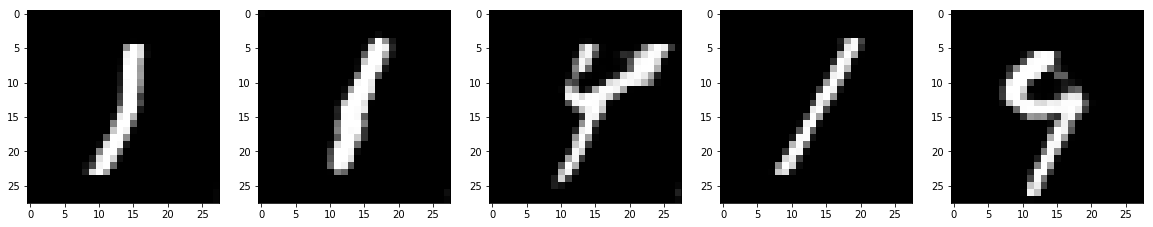

Training: █████████████████████████████████████████████░░░░░  90.00% (84240/93600) :: Epoch: 180 :: dis (fake and real)(loss-acc): (0.2444, 0.9844), (0.1988, 0.9844) :: gen loss: 5.7284

# Epoch 180


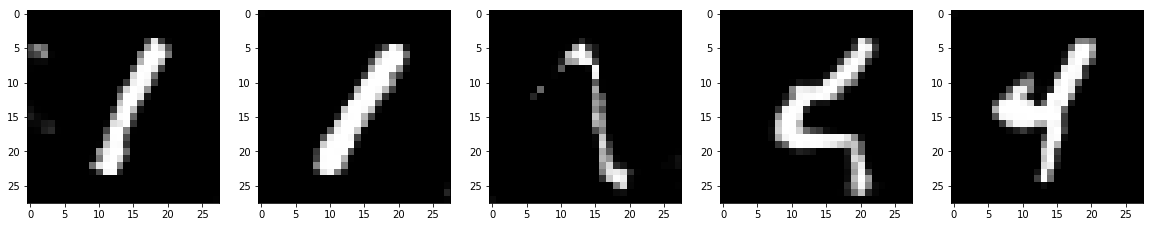

Training: ███████████████████████████████████████████████░░░  95.00% (88920/93600) :: Epoch: 190 :: dis (fake and real)(loss-acc): (0.2640, 0.9844), (0.2156, 0.9844) :: gen loss: 5.6877

# Epoch 190


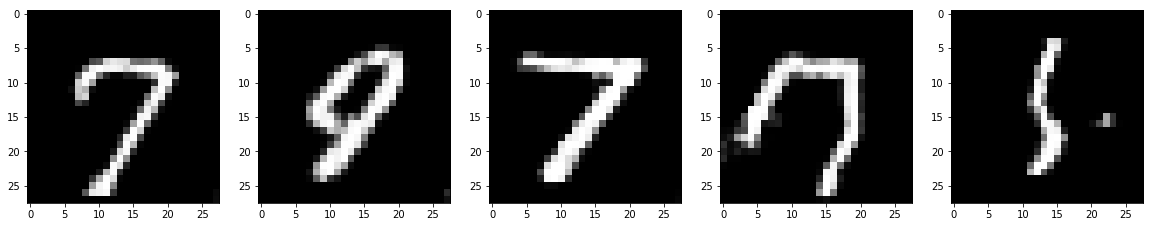

Training: ██████████████████████████████████████████████████ 100.00% (93600/93600) :: Epoch: 200 :: dis (fake and real)(loss-acc): (0.2590, 0.9922), (0.2199, 0.9922) :: gen loss: 5.2250


# Epoch 200


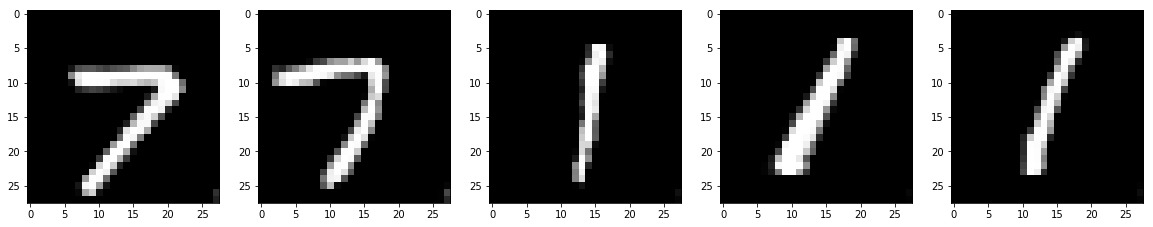

Wall time: 1h 32min 21s


In [13]:
%%time
p_bar = ProgressBar(total_iter=epochs*train_per_epoch, display_text="Training:", display_interval=10)
print(f"\n\nTraining for {epochs} epochs with {train_per_epoch} iterations per epoch")
for epoch in range(1, epochs+1):
    for batch_iter in range(train_per_epoch):
        latent_vectors = sampler.sample_latent()
        fake_data = sampler.sample_fake_data(latent_vectors)
        dis_fake_loss, dis_fake_acc = dis_model.train_on_batch(fake_data, np.zeros((fake_data.shape[0], 1)))
        real_data = sampler.sample_real_data()
        dis_real_loss, dis_real_acc = dis_model.train_on_batch(real_data, np.ones((real_data.shape[0], 1)))
        latent_vectors = sampler.sample_latent(2*batch_size)
        gen_loss = gan_model.train_on_batch(latent_vectors, np.ones((latent_vectors.shape[0], 1)))
        p_bar.step(add_text=f":: Epoch: {epoch} :: dis (fake and real)(loss-acc): ({dis_fake_loss:.4f}, {dis_fake_acc:.4f}), ({dis_real_loss:.4f}, {dis_real_acc:.4f}) :: gen loss: {gen_loss:.4f}")
        for key, value in zip(("dis_real_loss", "dis_real_acc", "dis_fake_loss", "dis_fake_acc", "gen_loss"), (dis_real_loss, dis_real_acc, dis_fake_loss, dis_fake_acc, gen_loss)):
            train_info[key].append(value)
    if not epoch%10:
        gen_images.extend(fake_data)
        latent_vectors = sampler.sample_latent(evaluate_num)
        gen_imgs = sampler.sample_fake_data(latent_vectors)
        fig = plt.figure(figsize=(20, 15))
        print(f"\n\n# Epoch {epoch}")
        plot_images(fig, imgs=gen_imgs, cols=evaluate_num)

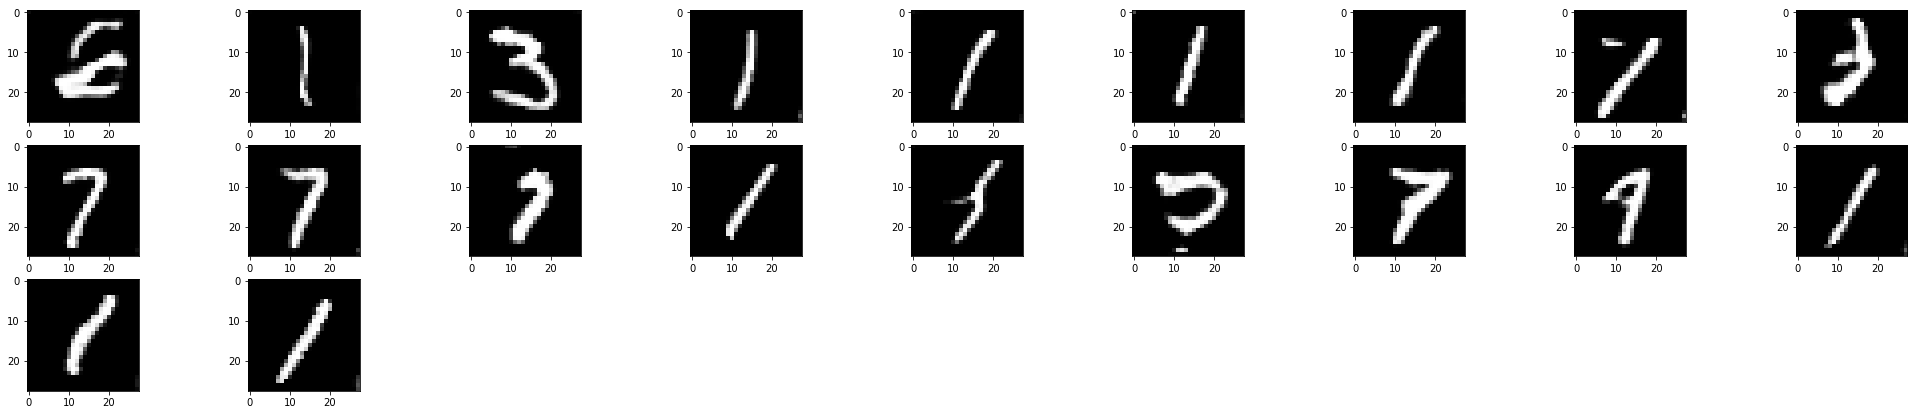

In [14]:
fig=plt.figure(figsize=(35, 7))
columns = 9
rows, rem = divmod(len(gen_images)/batch_size, columns)
if rem:
    rows += 1
for i in range(int(rows * columns - (columns - rem))):
    fig.add_subplot(rows, columns, i+1)
    batch_index = np.random.randint(0, batch_size)
    img = gen_images[i*batch_size + batch_index]
    plt.imshow(img[:, :, 0], cmap="gray")
plt.show()

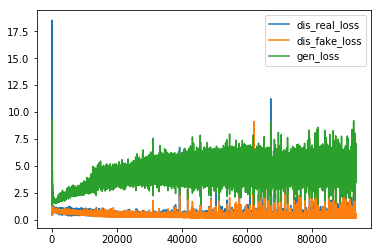

In [15]:
loss_legends = ("dis_real_loss", "dis_fake_loss", "gen_loss")
for label in loss_legends:
    plt.plot(label, data=train_info)
plt.legend(loss_legends)

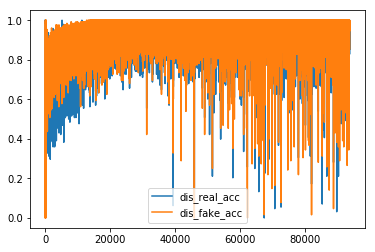

In [16]:
acc_legends = ("dis_real_acc", "dis_fake_acc")
for label in acc_legends:
    plt.plot(label, data=train_info)
plt.legend(acc_legends)

In [17]:
time_str = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
dump_dir = f"GAN_{time_str}"
os.makedirs(dump_dir, exist_ok=True)

In [18]:
gen_model.save(os.path.join(dump_dir, "generator.h5"))
dis_model.save(os.path.join(dump_dir, "discriminator.h5"))
gan_model.save(os.path.join(dump_dir, "combined.h5"))

In [19]:
new_dis = Model(inputs=[dis_model.layers[0].input], outputs=[dis_model.layers[6].output])

In [20]:
values = new_dis.predict(mnist_data[5:10])
values

array([[ 8.3779618e-03, -3.5869932e-01,  1.7032433e-01, -1.6665164e-02,
        -9.9878770e-01, -3.4561893e-01,  3.1524201e-04,  8.6086556e-02,
        -1.8190527e-02, -8.7398005e-01],
       [ 8.3779618e-03, -3.5869932e-01,  1.7032433e-01, -1.6665164e-02,
        -9.9878770e-01, -3.4562597e-01,  3.1524201e-04,  6.9863126e-02,
        -1.8190527e-02, -8.7397861e-01],
       [ 8.3779618e-03, -3.5869932e-01,  1.7032433e-01, -1.6665164e-02,
        -9.9878770e-01, -3.4561327e-01,  3.1524201e-04,  9.3788795e-02,
        -1.8190527e-02, -8.7397856e-01],
       [ 8.3779618e-03, -3.5869932e-01,  1.7032433e-01, -1.6665164e-02,
        -9.9878770e-01, -3.4565693e-01,  3.1524201e-04,  1.7382812e-02,
        -1.8190527e-02, -8.7398040e-01],
       [ 8.3779618e-03, -3.5869932e-01,  1.7032433e-01, -1.6665164e-02,
        -9.9878770e-01, -3.4564361e-01,  3.1524201e-04,  3.8844422e-02,
        -1.8190527e-02, -8.7397921e-01]], dtype=float32)

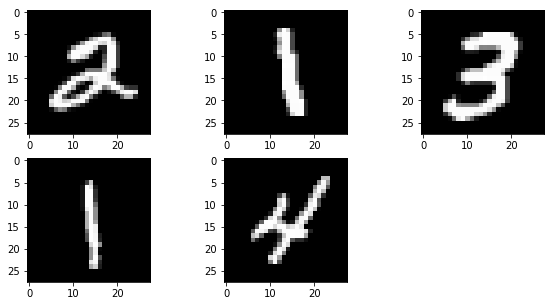

In [21]:
fig = plt.figure(figsize=(10, 5))
plot_images(fig, cols=3, imgs=mnist_data[5:10])

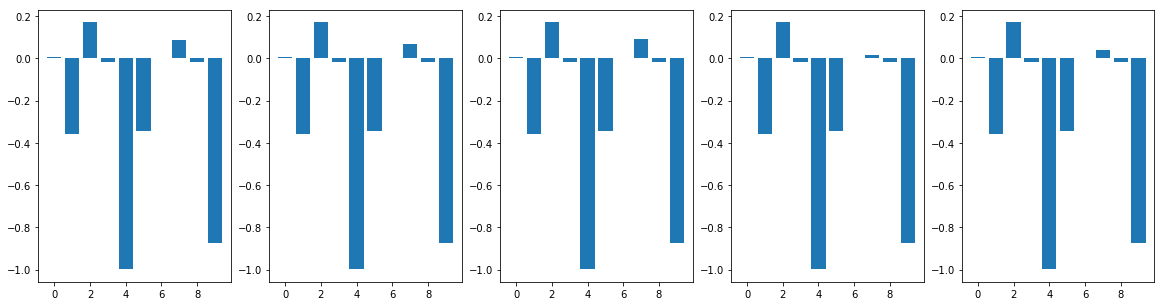

In [22]:
fig = plt.figure(figsize=(20, 5))
cols = values.shape[0]
rows = 1
for i, v in enumerate(values):
    fig.add_subplot(rows, cols, i+1)
    plt.bar(np.arange(v.shape[0]), v)
plt.show()